In [209]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tensorflow as tf
import tensorflow_probability as tfp
import gpytorch
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from scipy.stats import gamma, norm, beta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,  MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings


# datasets:
# pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 




EXAMPLE 1: SIMULATING REWARDS WITH STATISTICAL DISTRIBUTIONS (SYNTHETIC DATASET)

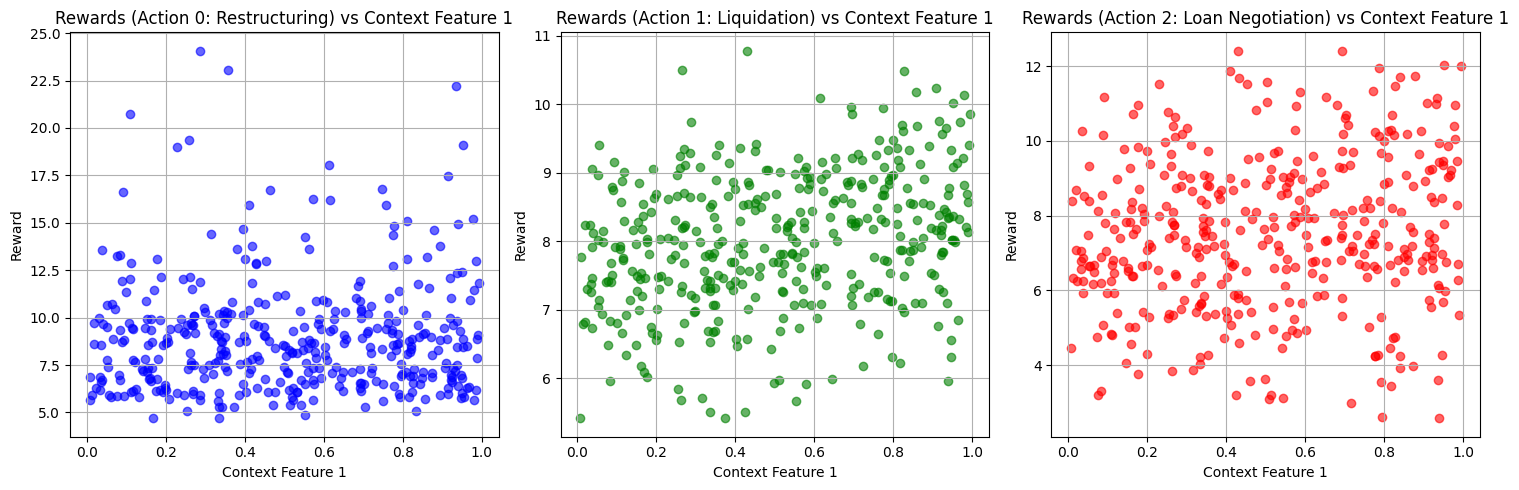

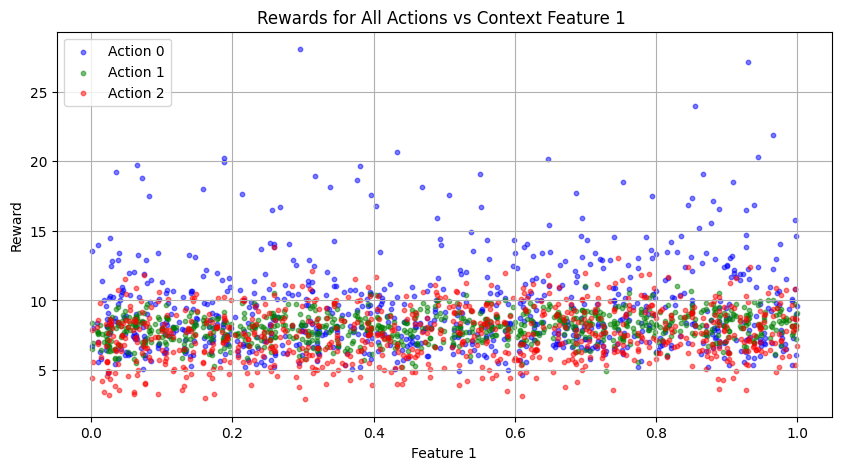

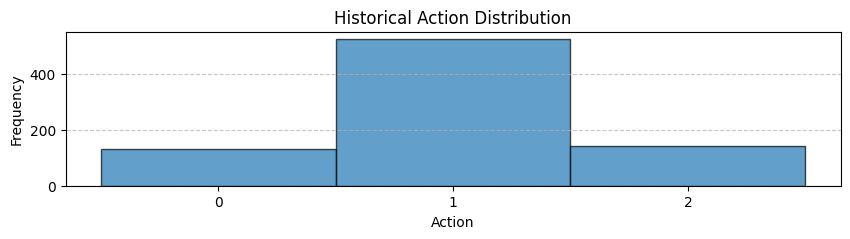

In [220]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Call the seed setting function
set_seed(42)


# Simulate random context data (features) for each sample
def simulate_context(total_samples, context_dim):
    return np.random.rand(total_samples, context_dim)  # Random context with `context_dim` features


def generate_rewards(context, action, true_theta, noise_level=0.2):
    total_samples = context.shape[0]
    rewards = np.zeros(total_samples)  # Initialize rewards array

    for i in range(total_samples):
        if action == 0:  # Restructuring (Gamma)
            # Compute Gamma parameters based on context
            gamma_shape = np.maximum(1.0, np.dot(context[i], true_theta[:, 0]) -5)  # Shape influenced by context
            gamma_scale = np.maximum(0.1, np.dot(context[i], true_theta[:, 1]) + 2)  # Scale influenced by context
            noise = gamma.rvs(a=gamma_shape, scale=gamma_scale * noise_level)
            rewards[i] = np.dot(context[i], true_theta[:, 0]) + noise
            
        elif action == 1:  # Loan Negotiation (Beta)
            # Compute Beta parameters based on context
            beta_alpha = np.maximum(0.1, np.dot(context[i], true_theta[:, 4]) )  # Ensure alpha influenced by context
            beta_beta = np.maximum(0.1, np.dot(context[i], true_theta[:, 5]) )   # Ensure beta influenced by context
            noise = beta.rvs(a=beta_alpha * noise_level, b=beta_beta * noise_level)
            rewards[i] = np.dot(context[i], true_theta[:, 2]) + noise
            
        elif action == 2:  # Liquidation (Normal)
            # Compute Normal parameters based on context
            normal_mean = np.dot(context[i], true_theta[:, 2] -0.25)  # Mean from context
            normal_stddev = np.maximum(0.1, np.dot(context[i], true_theta[:, 3]) )  # Volatility influenced by context
            noise = norm.rvs(loc=normal_mean, scale=normal_stddev * noise_level)
            rewards[i] = normal_mean + noise
            
        else:
            raise ValueError("Invalid action index. Must be 0, 1, or 2.")
    
    return rewards


# Function to generate synthetic data
def generate_synthetic_data(total_samples, true_theta):
    contexts = simulate_context(total_samples, context_dim)
    
    rewards_0 = generate_rewards(contexts, action=0, true_theta=true_theta)
    rewards_1 = generate_rewards(contexts, action=1, true_theta=true_theta)
    rewards_2 = generate_rewards(contexts, action=2, true_theta=true_theta)
    
    all_rewards = np.vstack([rewards_0, rewards_1, rewards_2]).T 
    rewards_0, rewards_1, rewards_2 = all_rewards[:, 0], all_rewards[:, 1], all_rewards[:, 2]
    
    return contexts, rewards_0, rewards_1, rewards_2



# Plotting the adjusted rewards vs context feature
def plot_rewards(contexts, rewards_0, rewards_1, rewards_2):
    num_features = contexts.shape[1]
    
    # Define consistent colors for each action
    action_colors = ['blue', 'green', 'red']
    
    plt.figure(figsize=(15, 5))
    
    # Plot for Restructuring (Gamma) with action 0 color
    plt.subplot(1, 3, 1)
    plt.scatter(contexts[:, 0], rewards_0, color=action_colors[0], alpha=0.6)
    plt.title("Rewards (Action 0: Restructuring) vs Context Feature 1")
    plt.xlabel("Context Feature 1")
    plt.ylabel("Reward")
    plt.grid(True)
    
    # Plot for  Liquidation (Normal)  with action 2 color
    plt.subplot(1, 3, 3)
    plt.scatter(contexts[:, 0], rewards_2, color=action_colors[2], alpha=0.6)
    plt.title("Rewards (Action 2: Loan Negotiation) vs Context Feature 1")
    plt.xlabel("Context Feature 1")
    plt.ylabel("Reward")
    plt.grid(True)

    # Plot for Loan Repayment Negotiation (Beta) with action 1 color
    plt.subplot(1, 3, 2)
    plt.scatter(contexts[:, 0], rewards_1, color=action_colors[1], alpha=0.6)
    plt.title("Rewards (Action 1: Liquidation) vs Context Feature 1")
    plt.xlabel("Context Feature 1")
    plt.ylabel("Reward")
    plt.grid(True)

    

    plt.tight_layout()
    plt.show()




        
# Function to generate synthetic data for all actions
def generate_data(total_samples, n_actions, context_dim, true_theta):
    contexts = simulate_context(total_samples, context_dim)
    rewards_all = []
    
    # Compute rewards for each action
    for action in range(n_actions):
        rewards_all.append(generate_rewards(contexts, action, true_theta)) 
    
    # Create a reward matrix (total_samples x n_actions)
    rewards = np.column_stack(rewards_all)
    
    # Find the optimal action for each context (the action with the maximum reward)
    optimal_actions = np.argmax(rewards, axis=1)
    
    return contexts, optimal_actions, rewards



# Define the data generation and splitting function
def generate_data_and_split(total_samples, n_actions, context_dim, true_theta):
    X, optimal_actions, rewards = generate_data(total_samples, n_actions, context_dim, true_theta)
    
    split_index = int(total_samples * 0.8)
    X_train = X[:split_index]
    historical_actions = generate_actions(split_index, n_actions)
    historical_rewards = rewards[:split_index]
    
    X_val = X[split_index:]
    optimal_actions_val = optimal_actions[split_index:]
    rewards_val = rewards[split_index:]
    
    return X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val

# Function to generate actions from a normal distribution and clip them to valid action range
def generate_actions(total_samples, n_actions):
    return np.clip(np.random.normal(loc=n_actions/2, scale=n_actions/6, size=total_samples), 0, n_actions-1).astype(int)

# Plotting a feature against rewards for all actions
def plot_feature_vs_rewards(X, rewards, feature_idx, dot_size=20):
    """
    Plots a single feature against the rewards for all actions.
    X: Features array of shape (total_samples, context_dim)
    rewards: Rewards array of shape (total_samples, n_actions)
    feature_idx: Index of the feature to plot (e.g., 0 for Feature 1)
    dot_size: Size of the dots in the scatter plot (default is 20)
    """
    
    # Define consistent colors for each action
    action_colors = ['blue', 'green', 'red']
    
    plt.figure(figsize=(10, 5))
    feature_values = X[:, feature_idx]
    
    # Loop over each action and use the same colors as the first script
    for action in range(rewards.shape[1]):  
        plt.scatter(feature_values, rewards[:, action], color=action_colors[action], label=f'Action {action}', alpha=0.5, s=dot_size)
    
    plt.xlabel(f'Feature {feature_idx + 1}')  # Adjust for 1-based indexing in the title
    plt.ylabel('Reward')
    plt.title(f'Rewards for All Actions vs Context Feature {feature_idx + 1} ')
    plt.legend()
    plt.grid(True)
    plt.show()



# Function to plot the distribution of actions
def plot_action_distribution(n_actions, actions):
    plt.figure(figsize=(10, 2))
    plt.hist(actions, bins=np.arange(n_actions + 1) - 0.5, edgecolor='black', alpha=0.7)
    plt.title('Historical Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.xticks(range(n_actions))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    


# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, lengthscale=1.0, outputscale=1.0):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, lengthscale=lengthscale)
        )
        self.covar_module.outputscale = outputscale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Define the GP Thompson Sampling class
class GPThompsonSampling:
    def __init__(self, n_actions, context_dim, num_samples=10, lengthscale=1.0, outputscale=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.num_samples = num_samples
        self.lengthscale = lengthscale
        self.outputscale = outputscale
        self.models = [None] * n_actions
        self.likelihoods = [gpytorch.likelihoods.GaussianLikelihood() for _ in range(n_actions)]

    def update(self, actions, rewards, contexts):
        contexts = torch.tensor(contexts, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)

        for action in range(self.n_actions):
            indices = (actions == action)
            if indices.sum().item() == 0:
                continue

            X_train_action = contexts[indices]
            y_train_action = rewards[indices, action]

            # Initialize and train the GP model for this action
            self.models[action] = ExactGPModel(X_train_action, y_train_action, self.likelihoods[action], 
                                               lengthscale=self.lengthscale, outputscale=self.outputscale)
            self.models[action].train()
            optimizer = torch.optim.Adam(self.models[action].parameters(), lr=0.1)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihoods[action], self.models[action])

            for _ in range(50):  # Number of training epochs
                optimizer.zero_grad()
                output = self.models[action](X_train_action)

                if y_train_action.dim() > 1:
                    y_train_action = y_train_action.squeeze(-1)

                loss = -mll(output, y_train_action)
                
                if loss.numel() != 1:
                    raise ValueError(f"Expected scalar loss, but got shape {loss.shape}")

                loss.backward()
                optimizer.step()

    def predict(self, context):
        context = torch.tensor(context, dtype=torch.float32)
        means = np.zeros((context.shape[0], self.n_actions))
        stddevs = np.zeros((context.shape[0], self.n_actions))
        for action in range(self.n_actions):
            if self.models[action] is None:
                means[:, action] = np.random.randn(context.shape[0])
                stddevs[:, action] = np.ones(context.shape[0])
            else:
                self.models[action].eval()
                gp_samples = self.sample_from_gp_posterior(self.models[action], context, self.num_samples)
                means[:, action] = gp_samples.mean(dim=0).numpy()
                stddevs[:, action] = gp_samples.std(dim=0).numpy()
        return means, stddevs

    def sample_from_gp_posterior(self, model, context, num_samples):
        with torch.no_grad():
            posterior = model(context)
            samples = posterior.sample(sample_shape=torch.Size([num_samples]))
        return samples
    
    
# Define the Bayesian Neural Network (BNN) model using TensorFlow Probability
class BayesianNN(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim, num_samples):
        super(BayesianNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_samples = num_samples

        self.hidden = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.out = tf.keras.layers.Dense(output_dim)

        self.prior = tfp.layers.default_mean_field_normal_fn()
        self.posterior = tfp.layers.default_mean_field_normal_fn()

    def call(self, x):
        x = self.hidden(x)
        x = self.out(x)
        return x

    def build_bayesian_layers(self):
        self.hidden_bnn = tfp.layers.DenseVariational(
            units=self.hidden_dim,
            make_posterior_fn=self.posterior,
            make_prior_fn=self.prior,
            activation='relu'
        )
        self.out_bnn = tfp.layers.DenseVariational(
            units=self.output_dim,
            make_posterior_fn=self.posterior,
            make_prior_fn=self.prior
        )

    def train_step(self, data):
        contexts, rewards, actions = data
        with tf.GradientTape() as tape:
            logits = self(contexts, training=True)

            # Define the scale_diag to match the logits' shape
            scale_diag = tf.ones_like(logits)
            
            # Use MultivariateNormalDiag with the appropriate scale_diag shape
            distribution = tfp.distributions.MultivariateNormalDiag(loc=logits, scale_diag=scale_diag)
            log_likelihood = tf.reduce_sum(distribution.log_prob(rewards))
            loss = -log_likelihood

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        contexts, rewards, actions = data
        logits = self(contexts, training=False)

        scale_diag = tf.ones_like(logits)
        distribution = tfp.distributions.MultivariateNormalDiag(loc=logits, scale_diag=scale_diag)
        log_likelihood = tf.reduce_sum(distribution.log_prob(rewards))
        loss = -log_likelihood
        return {"loss": loss}

    def predict(self, contexts):
        means = np.zeros((contexts.shape[0], self.output_dim))
        stddevs = np.zeros((contexts.shape[0], self.output_dim))

        # Sample from the Bayesian model's posterior
        for _ in range(self.num_samples):
            logits = self(contexts, training=False)
            means += logits.numpy()
            stddevs += np.std(logits.numpy(), axis=0)  # Approximate std deviation

        means /= self.num_samples
        stddevs /= self.num_samples
        return means, stddevs
    
    def thompson_sampling(self, contexts):
        # For Thompson Sampling, we sample from the BNN's posterior once per context
        logits = self(contexts, training=False).numpy()  # This is a single sample

        # Select the action with the highest sampled logit (optimal action)
        selected_actions = np.argmax(logits, axis=1)

        return selected_actions, logits


    

# Ridge regression model class
class RidgeRegression:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.models = [Ridge(alpha=1.0) for _ in range(n_actions)]

    def fit(self, contexts, rewards, actions):
        contexts = np.array(contexts)
        rewards = np.array(rewards)
        actions = np.array(actions)
        for action in range(self.n_actions):
            indices = (actions == action)
            if indices.sum() > 0:
                X_train_action = contexts[indices]
                y_train_action = rewards[indices, action]
                self.models[action].fit(X_train_action, y_train_action)

    def predict(self, contexts):
        contexts = np.array(contexts)
        predictions = np.zeros((contexts.shape[0], self.n_actions))
        for action in range(self.n_actions):
            predictions[:, action] = self.models[action].predict(contexts)
        return predictions

# Random strategy class
class RandomStrategy:
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def predict(self, contexts):
        contexts = np.array(contexts)
        return np.random.randint(0, self.n_actions, size=(contexts.shape[0],))
    
# Function to plot GP Thompson Sampling predictions with uncertainty
def plot_bnn_uncertainty(contexts, means, stddevs, num_samples=10):
    x = np.arange(contexts.shape[0])
    plt.figure(figsize=(12, 2))
    plt.plot(x, means[:, 0], label='BNN Thompson Sampling Mean Predictions')
    plt.fill_between(x, means[:, 0] - 1.96 * stddevs[:, 0], means[:, 0] + 1.96 * stddevs[:, 0], color='blue', alpha=0.2, label='95% Confidence Interval')
    plt.title('BNN Thompson Sampling Predictions with Uncertainty')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Mean Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_bnn_predictions_with_uncertainty(contexts, means, stddevs, n_actions):
    plt.figure(figsize=(12, 2))
    
    # Plot each action's predictions with uncertainty
    for action in range(n_actions):
        x = np.arange(contexts.shape[0])
        plt.errorbar(x, means[:, action], yerr=1.96 * stddevs[:, action], fmt='o', label=f'Action {action}')
    
    plt.title('BNN Thompson Sampling Predictions with Uncertainty')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Reward')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    

# Updated LinUCB class
class LinUCB:
    def __init__(self, n_actions, context_dim, alpha=.5):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha
        self.A = [np.identity(context_dim) for _ in range(n_actions)]  # d x d identity matrix
        self.b = [np.zeros(context_dim) for _ in range(n_actions)]      # d x 1 zero vector

    def update(self, action, reward, context):
        context = np.array(context)
        self.A[action] += np.outer(context, context)
        self.b[action] += reward * context

    def predict(self, contexts):
        contexts = np.array(contexts)
        p = np.zeros((contexts.shape[0], self.n_actions))
        for i in range(contexts.shape[0]):
            for action in range(self.n_actions):
                A_inv = np.linalg.inv(self.A[action])
                theta = np.dot(A_inv, self.b[action])
                p[i, action] = np.dot(theta, contexts[i]) + self.alpha * np.sqrt(np.dot(contexts[i], np.dot(A_inv, contexts[i])))
        return p
    
    
# Function to plot comparison of optimal actions and GP Thompson Sampling actions
def plot_optimal_vs_gp_ts(optimal_actions, gp_ts_preds):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(gp_ts_preds)) + 2) - 0.5
    
    # Plot histograms for optimal actions and GP TS predictions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(gp_ts_preds, bins=bins, edgecolor='black', alpha=0.5, label='GP Thompson Sampling Actions')
    
    plt.title('Comparison of Optimal Actions vs GP Thompson Sampling Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_optimal_vs_linucb(optimal_actions, linucb_actions):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(linucb_actions)) + 2) - 0.5
    
    # Plot histograms for optimal actions and LinUCB actions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(linucb_actions, bins=bins, edgecolor='black', alpha=0.5, label='LinUCB Actions')
    
    plt.title('Comparison of Optimal Actions vs LinUCB Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_optimal_vs_bnn(optimal_actions, bnn_actions):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(bnn_actions)) + 2) - 0.5
    
    # Plot histograms for optimal actions and LinUCB actions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(bnn_actions, bins=bins, edgecolor='black', alpha=0.5, label='BNN Thompson Sampling Actions')
    
    plt.title('Comparison of Optimal Actions vs BNN Thompson Sampling Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()





def run_backtest(total_samples, n_actions, context_dim, num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=20):
    
    X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
        total_samples, n_actions, context_dim, true_theta)
    
    
    # GP Thompson Sampling
    gp_ts_model = GPThompsonSampling(n_actions, context_dim, num_samples, lengthscale, outputscale)
    gp_ts_model.update(historical_actions, historical_rewards, X_train)
    gp_ts_means, gp_ts_stddevs = gp_ts_model.predict(X_val)
    gp_ts_preds = np.argmax(gp_ts_means, axis=1)
    
    # Ridge Regression
    ridge_model = RidgeRegression(n_actions)
    ridge_model.fit(X_train, historical_rewards, historical_actions)
    ridge_preds = ridge_model.predict(X_val)
    ridge_preds = np.argmax(ridge_preds, axis=1)
    
    # LinUCB
    lin_UCB_model = LinUCB(n_actions, context_dim, alpha=0.5)
    for i in range(len(historical_actions)):
        lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])
    lin_UCB_preds = lin_UCB_model.predict(X_val)
    lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)
    
    # Random Strategy
    random_strategy = RandomStrategy(n_actions)
    random_preds = random_strategy.predict(X_val)
    
    
   
    # Bayesian Neural Network
    # Initialize the Bayesian Neural Network model
    hidden_dim = 40
    num_samples = 10
    bnn_model = BayesianNN(input_dim=context_dim, hidden_dim=hidden_dim, output_dim=n_actions, num_samples=num_samples)
    bnn_model.build_bayesian_layers()  # Build Bayesian layers
    
    # Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    bnn_model.optimizer = optimizer
    # Update the model with training data
    # Train the model
    dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), historical_rewards.astype(np.float32), historical_actions.astype(np.int32)))
    dataset = dataset.batch(32)
    for epoch in range(epochs):
        for step, batch_data in enumerate(dataset):
            loss = bnn_model.train_step(batch_data)
        if epoch % 10 == 0:
                print(f"Epoch {epoch}, Step {step}: Loss = {loss['loss'].numpy()}")
                
    bnn_means, bnn_stddevs = bnn_model.predict(X_val)
    bnn_preds, sampled_logits = bnn_model.thompson_sampling(X_val)
    
    
    
    
    
    all_true_rewards = np.zeros((X_val.shape[0], n_actions))
    for action in range(n_actions):
        all_true_rewards[:, action] = generate_rewards(X_val, action, true_theta)
    
    true_rewards = np.max(all_true_rewards, axis=1)
    
    gp_ts_rewards = np.array([all_true_rewards[i, gp_ts_preds[i]] for i in range(len(gp_ts_preds))])
    ridge_rewards = np.array([all_true_rewards[i, ridge_preds[i]] for i in range(len(ridge_preds))])
    random_rewards = np.array([all_true_rewards[i, random_preds[i]] for i in range(len(random_preds))])
    lin_UCB_rewards = np.array([all_true_rewards[i, lin_UCB_preds[i]] for i in range(len(lin_UCB_preds))])
    bnn_rewards = np.array([all_true_rewards[i, bnn_preds[i]] for i in range(len(bnn_preds))])
    
    plt.figure(figsize=(12, 5))
    plt.plot(np.cumsum(true_rewards), label='Optimal Policy', linestyle='--')
    plt.plot(np.cumsum(bnn_rewards), label='BNN Thompson Sampling')
    plt.plot(np.cumsum(gp_ts_rewards), label='GP Thompson Sampling')
    plt.plot(np.cumsum(lin_UCB_rewards), label='Lin_UCB Strategy')
    plt.plot(np.cumsum(ridge_rewards), label='Ridge Regression')
    plt.plot(np.cumsum(random_rewards), label='Random Strategy')
    
  
    plt.title('Cumulative Rewards')
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


    # Plot GP Thompson Sampling predictions with uncertainty
    plot_bnn_uncertainty(X_val, bnn_means, bnn_stddevs)
    plot_bnn_predictions_with_uncertainty(X_val, bnn_means, bnn_stddevs, n_actions)
    plot_optimal_vs_bnn(optimal_actions_val, bnn_preds)
    plot_optimal_vs_gp_ts(optimal_actions_val, gp_ts_preds)
    plot_optimal_vs_linucb(optimal_actions_val, lin_UCB_preds)
    
    
    print(f"BNN Thompson Sampling Accuracy: {accuracy_score(optimal_actions_val, bnn_preds):.4f}")
    print(f"BNN Thompson Sampling F1 Score: {f1_score(optimal_actions_val, bnn_preds, average='weighted'):.4f}")

    print(f"GP Thompson Sampling Accuracy: {accuracy_score(optimal_actions_val, gp_ts_preds):.4f}")
    print(f"GP Thompson Sampling F1 Score: {f1_score(optimal_actions_val, gp_ts_preds, average='weighted'):.4f}")
    
    print(f"LinUCB Accuracy: {accuracy_score(optimal_actions_val, lin_UCB_preds):.4f}")
    print(f"LinUCB F1 Score: {f1_score(optimal_actions_val, lin_UCB_preds, average='weighted'):.4f}")
    
 
    print(f"Ridge Regression Accuracy: {accuracy_score(optimal_actions_val, ridge_preds):.4f}")
    print(f"Ridge Regression F1 Score: {f1_score(optimal_actions_val, ridge_preds, average='weighted'):.4f}")

    print(f"Random Strategy Accuracy: {accuracy_score(optimal_actions_val, random_preds):.4f}")
    print(f"Random Strategy F1 Score: {f1_score(optimal_actions_val, random_preds, average='weighted'):.4f}")

    

# Example usage
total_samples = 1000
n_actions = 3
context_dim = 30

# Coefficients for reward functions
true_theta = np.random.rand(context_dim, 6)  # 2 parameters for each action


contexts, rewards_0, rewards_1, rewards_2 = generate_synthetic_data(total_samples=400, true_theta=true_theta)

X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
        total_samples, n_actions, context_dim, true_theta)

# Plot for Feature 1 (i.e., feature_idx = 0)
plot_rewards(contexts, rewards_0, rewards_1, rewards_2)
plot_feature_vs_rewards(X_train, historical_rewards, feature_idx=0, dot_size=10)
plot_action_distribution(n_actions, historical_actions)

Epoch 0, Step 24: Loss = 374.0545349121094
Epoch 10, Step 24: Loss = 251.10638427734375
Epoch 20, Step 24: Loss = 229.91061401367188
Epoch 30, Step 24: Loss = 225.2850341796875
Epoch 40, Step 24: Loss = 221.61196899414062


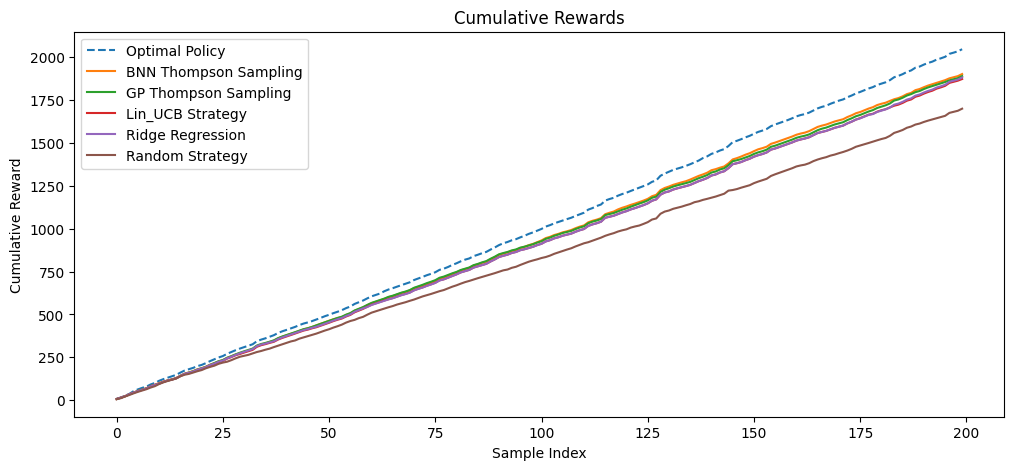

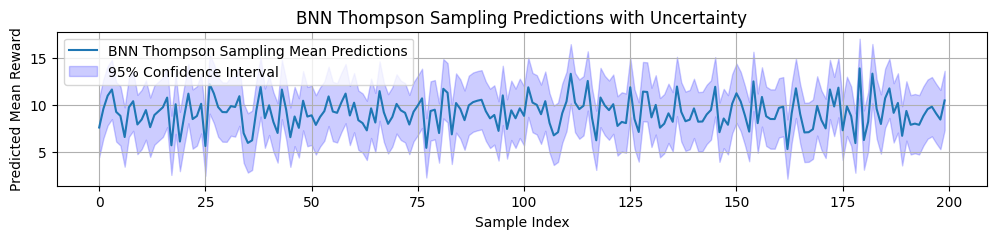

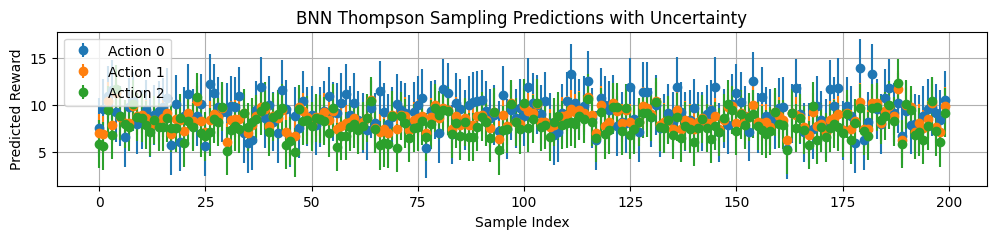

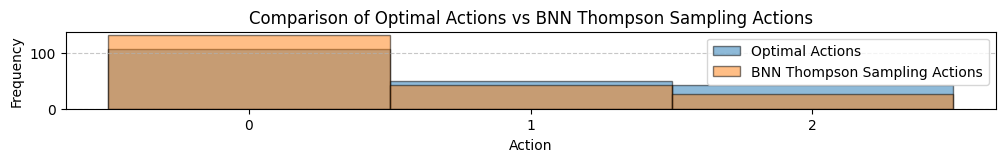

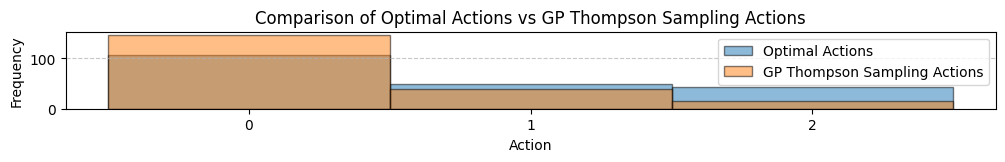

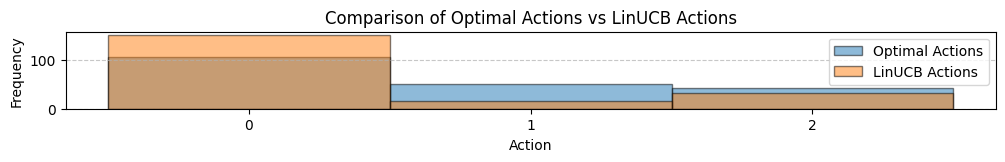

BNN Thompson Sampling Accuracy: 0.6100
BNN Thompson Sampling F1 Score: 0.5854
GP Thompson Sampling Accuracy: 0.5700
GP Thompson Sampling F1 Score: 0.5271
LinUCB Accuracy: 0.5450
LinUCB F1 Score: 0.4888
Ridge Regression Accuracy: 0.5500
Ridge Regression F1 Score: 0.5055
Random Strategy Accuracy: 0.3400
Random Strategy F1 Score: 0.3502


In [221]:
run_backtest(total_samples, n_actions, context_dim, num_samples=30, lengthscale=0.5, outputscale=2, epochs=50)

In [4]:
 
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
data = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets.values - 1 ## 1 subtracted for (0 = Good,  1 = Bad) labelling
  
# metadata 
#print(statlog_german_credit_data.metadata) 
  
# variable information 
#print(statlog_german_credit_data.variables) 


In [5]:
statlog_german_credit_data.variables

,name,role,type,demographic,description,units,missing_values
0,Attribute1,Feature,Categorical,None,Status of existing checking account,None,no
1,Attribute2,Feature,Integer,None,Duration,months,no
2,Attribute3,Feature,Categorical,None,Credit history,None,no
3,Attribute4,Feature,Categorical,None,Purpose,None,no
4,Attribute5,Feature,Integer,None,Credit amount,None,no
5,Attribute6,Feature,Categorical,None,Savings account/bonds,None,no
6,Attribute7,Feature,Categorical,Other,Present employment since,None,no
7,Attribute8,Feature,Integer,None,Installment rate in percentage of disposable i...,None,no
8,Attribute9,Feature,Categorical,Marital Status,Personal status and sex,None,no
9,Attribute10,Feature,Categorical,None,Other debtors / guarantors,None,no


In [6]:
df=data[statlog_german_credit_data.variables.name[:-1]]
df_full=df.copy()
df_full.columns=statlog_german_credit_data.variables.description[:-1].to_list()
df_full

,Status of existing checking account,Duration,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201


In [8]:

# Define preprocessing steps
numeric_features = ['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
binary_features = ['Attribute19', 'Attribute20']
categorical_features = ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17']

# Apply LabelEncoder to binary features
label_encoders = {}
for feature in binary_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le  # Store the encoder for future use (e.g., inverse transform)

# Pipeline for numeric features: Imputation and Min-Max Scaling between -1 and 1
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

# Pipeline for categorical features: Imputation, OneHotEncoding, and Min-Max Scaling between -1 and 1
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),  # Set sparse=False for easy concatenation
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))  # Scaling the one-hot encoded features
])

# For binary features, use Min-Max Scaling as well
binary_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))
])

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features)
    ]
)

# Apply the preprocessing steps to the DataFrame
df2 = preprocessor.fit_transform(df)

# If you want to convert it back to a DataFrame for ease of use
# Create column names for the one-hot encoded features
onehot_feature_names = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out())

# Combine all feature names
all_feature_names = numeric_features + onehot_feature_names + binary_features

# Create the processed DataFrame
df2 = pd.DataFrame(df2, columns=all_feature_names)

# Show the processed DataFrame
df2


,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18,x0_A11,x0_A12,x0_A13,...,x8_A143,x9_A151,x9_A152,x9_A153,x10_A171,x10_A172,x10_A173,x10_A174,Attribute19,Attribute20
0,-0.941176,-0.898867,1.000000,1.000000,0.714286,-0.333333,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
1,0.294118,-0.372620,-0.333333,-0.333333,-0.892857,-1.000000,-1.0,-1.0,1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2,-0.764706,-0.796853,-0.333333,0.333333,0.071429,-1.000000,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
3,0.117647,-0.160119,-0.333333,1.000000,-0.071429,-1.000000,1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,-0.411765,-0.491581,0.333333,1.000000,0.214286,-0.333333,1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.764706,-0.836470,0.333333,1.000000,-0.571429,-1.000000,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
996,-0.235294,-0.603059,1.000000,1.000000,-0.250000,-1.000000,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
997,-0.764706,-0.939034,1.000000,1.000000,-0.321429,-1.000000,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
998,0.205882,-0.824475,1.000000,1.000000,-0.857143,-1.000000,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0


In [149]:

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Call the seed setting function
set_seed(42)


# RewardGenerator and generate_data functions (from your code)
class RewardGenerator:
    def __init__(self, drift_rate=0.005, seasonal_period=400):
        self.drift_rate = drift_rate
        self.seasonal_period = seasonal_period
        self.t = 0  # Initialize time step

    def generate_rewards(self, context, action, optimal_action, n=3):
        """
        Generates rewards with added complexity from context sampling and non-stationarity.

        Parameters:
        - context: np.array, the feature context
        - action: int, the action taken
        - optimal_action: int, the optimal action for this context
        - n: int, number of context features to sample for reward generation

        Returns:
        - reward: float, the generated reward
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than n
        
        # Compute a context factor based on the sampled features
        context_factor = np.sum(sampled_context)
        
        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)
        
        # Calculate reward based on action and non-stationary factors
        if action == optimal_action:
            mean = 1 + 0.2 * context_factor + time_drift + seasonality
            std = 0.1  # Small variance for optimal action
        else:
            mean = 0 + 0.5 * context_factor + time_drift + seasonality
            std = 0.4  # Higher variance for non-optimal action
        
        # Sample reward from Gaussian distribution
        reward = np.random.normal(mean, std)

        # Increment time step for next call
        self.t += 1
        
        return reward




# Example usage in your data generation function
def generate_data(context, total_samples, n_actions, optimal_actions):
    rewards = torch.zeros(total_samples, n_actions)
    
    
    reward_gen = RewardGenerator()



    for i in range(total_samples):
        for action in range(n_actions):
            # Generate rewards based on the given logic
            rewards[i, action] = reward_gen.generate_rewards(context[i], action,  optimal_actions[i])
    #        rewards[i, action] = generate_rewards(context[i], action, optimal_actions[i])

    return rewards


# Function to generate actions from a normal distribution and clip them to valid action range
def generate_actions(total_samples):
    return  np.random.choice([0, 1], size=total_samples)

# Define the data generation and splitting function
def generate_data_and_split(X, total_samples, n_actions, optimal_actions   ):
    
    rewards=generate_data(X, total_samples, n_actions, optimal_actions)
    split_index = int(total_samples * 0.9)
    X_train = X[:split_index]
    historical_actions = generate_actions(split_index)
    historical_rewards = rewards[:split_index]
    
    X_val = X[split_index:]
    optimal_actions_val = optimal_actions[split_index:]
    rewards_val = rewards[split_index:]
    
    return X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val



def plot_feature_vs_rewards(X, rewards, feature_idx, dot_size=20):
    """
    Plots a single feature against the rewards for all actions.
    X: Features array of shape (total_samples, context_dim)
    rewards: Rewards array of shape (total_samples, n_actions)
    feature_idx: Index of the feature to plot (e.g., 0 for Feature 1)
    dot_size: Size of the dots in the scatter plot (default is 20)
    """
    plt.figure(figsize=(10, 5))
    feature_values = X[:, feature_idx]
    
    for action in range(rewards.shape[1]):  # Loop over each action
        plt.scatter(feature_values, rewards[:, action], label=f'Action {action}', alpha=0.5, s=dot_size)
    
    plt.xlabel(f'Feature {feature_idx + 1}')  # Adjust for 1-based indexing in the title
    plt.ylabel('Reward')
    plt.title(f'Feature {feature_idx + 1} vs Rewards for All Actions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot the distribution of actions
def plot_action_distribution(n_actions, actions):
    plt.figure(figsize=(10, 2))
    plt.hist(actions, bins=np.arange(n_actions + 1) - 0.5, edgecolor='black', alpha=0.7)
    plt.title('Historical Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.xticks(range(n_actions))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    



# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, lengthscale=1.0, outputscale=1.0):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, lengthscale=lengthscale)
        )
        self.covar_module.outputscale = outputscale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Define the GP Thompson Sampling class
class GPThompsonSampling:
    def __init__(self, n_actions, context_dim, num_samples=10, lengthscale=1.0, outputscale=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.num_samples = num_samples
        self.lengthscale = lengthscale
        self.outputscale = outputscale
        self.models = [None] * n_actions
        self.likelihoods = [gpytorch.likelihoods.GaussianLikelihood() for _ in range(n_actions)]

    def update(self, actions, rewards, contexts):
        contexts = torch.tensor(contexts, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)

        for action in range(self.n_actions):
            indices = (actions == action)
            if indices.sum().item() == 0:
                continue

            X_train_action = contexts[indices]
            y_train_action = rewards[indices, action]

            # Initialize and train the GP model for this action
            self.models[action] = ExactGPModel(X_train_action, y_train_action, self.likelihoods[action], 
                                               lengthscale=self.lengthscale, outputscale=self.outputscale)
            self.models[action].train()
            optimizer = torch.optim.Adam(self.models[action].parameters(), lr=0.1)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihoods[action], self.models[action])

            for _ in range(100):  # Number of training epochs
                optimizer.zero_grad()
                output = self.models[action](X_train_action)

                if y_train_action.dim() > 1:
                    y_train_action = y_train_action.squeeze(-1)

                loss = -mll(output, y_train_action)
                
                if loss.numel() != 1:
                    raise ValueError(f"Expected scalar loss, but got shape {loss.shape}")

                loss.backward()
                optimizer.step()

    def predict(self, context):
        context = torch.tensor(context, dtype=torch.float32)
        means = np.zeros((context.shape[0], self.n_actions))
        stddevs = np.zeros((context.shape[0], self.n_actions))
        for action in range(self.n_actions):
            if self.models[action] is None:
                means[:, action] = np.random.randn(context.shape[0])
                stddevs[:, action] = np.ones(context.shape[0])
            else:
                self.models[action].eval()
                gp_samples = self.sample_from_gp_posterior(self.models[action], context, self.num_samples)
                means[:, action] = gp_samples.mean(dim=0).numpy()
                stddevs[:, action] = gp_samples.std(dim=0).numpy()
        return means, stddevs

    def sample_from_gp_posterior(self, model, context, num_samples):
        with torch.no_grad():
            posterior = model(context)
            samples = posterior.sample(sample_shape=torch.Size([num_samples]))
        return samples
    
    
# Define the Bayesian Neural Network (BNN) model using TensorFlow Probability
class BayesianNN(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim, num_samples):
        super(BayesianNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_samples = num_samples

        self.hidden = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.out = tf.keras.layers.Dense(output_dim)

        self.prior = tfp.layers.default_mean_field_normal_fn()
        self.posterior = tfp.layers.default_mean_field_normal_fn()

    def call(self, x):
        x = self.hidden(x)
        x = self.out(x)
        return x

    def build_bayesian_layers(self):
        self.hidden_bnn = tfp.layers.DenseVariational(
            units=self.hidden_dim,
            make_posterior_fn=self.posterior,
            make_prior_fn=self.prior,
            activation='relu'
        )
        self.out_bnn = tfp.layers.DenseVariational(
            units=self.output_dim,
            make_posterior_fn=self.posterior,
            make_prior_fn=self.prior
        )

    def train_step(self, data):
        contexts, rewards, actions = data
        with tf.GradientTape() as tape:
            logits = self(contexts, training=True)

            # Define the scale_diag to match the logits' shape
            scale_diag = tf.ones_like(logits)
            
            # Use MultivariateNormalDiag with the appropriate scale_diag shape
            distribution = tfp.distributions.MultivariateNormalDiag(loc=logits, scale_diag=scale_diag)
            log_likelihood = tf.reduce_sum(distribution.log_prob(rewards))
            loss = -log_likelihood

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        contexts, rewards, actions = data
        logits = self(contexts, training=False)

        scale_diag = tf.ones_like(logits)
        distribution = tfp.distributions.MultivariateNormalDiag(loc=logits, scale_diag=scale_diag)
        log_likelihood = tf.reduce_sum(distribution.log_prob(rewards))
        loss = -log_likelihood
        return {"loss": loss}

    def predict(self, contexts):
        means = np.zeros((contexts.shape[0], self.output_dim))
        stddevs = np.zeros((contexts.shape[0], self.output_dim))

        # Sample from the Bayesian model's posterior
        for _ in range(self.num_samples):
            logits = self(contexts, training=False)
            means += logits.numpy()
            stddevs += np.std(logits.numpy(), axis=0)  # Approximate std deviation

        means /= self.num_samples
        stddevs /= self.num_samples
        return means, stddevs
    
    def thompson_sampling(self, contexts):
        # For Thompson Sampling, we sample from the BNN's posterior once per context
        logits = self(contexts, training=False).numpy()  # This is a single sample

        # Select the action with the highest sampled logit (optimal action)
        selected_actions = np.argmax(logits, axis=1)

        return selected_actions, logits


    

# Ridge regression model class
class RidgeRegression:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.models = [Ridge(alpha=1.0) for _ in range(n_actions)]

    def fit(self, contexts, rewards, actions):
        contexts = np.array(contexts)
        rewards = np.array(rewards)
        actions = np.array(actions)
        for action in range(self.n_actions):
            indices = (actions == action)
            if indices.sum() > 0:
                X_train_action = contexts[indices]
                y_train_action = rewards[indices, action]
                self.models[action].fit(X_train_action, y_train_action)

    def predict(self, contexts):
        contexts = np.array(contexts)
        predictions = np.zeros((contexts.shape[0], self.n_actions))
        for action in range(self.n_actions):
            predictions[:, action] = self.models[action].predict(contexts)
        return predictions

# Random strategy class
class RandomStrategy:
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def predict(self, contexts):
        contexts = np.array(contexts)
        return np.random.randint(0, self.n_actions, size=(contexts.shape[0],))
    
# Function to plot GP Thompson Sampling predictions with uncertainty
def plot_bnn_uncertainty(contexts, means, stddevs, num_samples=10):
    x = np.arange(contexts.shape[0])
    plt.figure(figsize=(12, 2))
    plt.plot(x, means[:, 0], label='BNN Thompson Sampling Mean Predictions')
    plt.fill_between(x, means[:, 0] - 1.96 * stddevs[:, 0], means[:, 0] + 1.96 * stddevs[:, 0], color='blue', alpha=0.2, label='95% Confidence Interval')
    plt.title('BNN Thompson Sampling Predictions with Uncertainty')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Mean Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_bnn_predictions_with_uncertainty(contexts, means, stddevs, n_actions):
    plt.figure(figsize=(12, 2))
    
    # Plot each action's predictions with uncertainty
    for action in range(n_actions):
        x = np.arange(contexts.shape[0])
        plt.errorbar(x, means[:, action], yerr=1.96 * stddevs[:, action], fmt='o', label=f'Action {action}')
    
    plt.title('BNN Thompson Sampling Predictions with Uncertainty')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Reward')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    
class LinUCB:
    def __init__(self, n_actions, context_dim, alpha=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha

        # Initialize A as identity matrices for each action
        self.A = [np.eye(context_dim) for _ in range(n_actions)]

        # Initialize b as zero arrays for each action
        self.b = [np.zeros(context_dim) for _ in range(n_actions)]

    def update(self, action, reward, context):
        context = np.array(context)

        # Ensure context shape matches b[action]
        if context.shape != self.b[action].shape:
            raise ValueError(f"Context shape {context.shape} does not match expected shape {self.b[action].shape}")

        # Update A and b using outer product of context
        self.A[action] += np.outer(context, context)

        # Convert reward to a scalar if it's a zero-dimensional tensor
        if isinstance(reward, torch.Tensor) and reward.ndim == 0:
            reward = reward.item()

        # Now reward is guaranteed to be a scalar
        self.b[action] += reward * context

    def predict(self, contexts):
        contexts = np.array(contexts)
        preds = np.zeros((contexts.shape[0], self.n_actions))

        for i, context in enumerate(contexts):
            for action in range(self.n_actions):
                A_inv = np.linalg.inv(self.A[action])
                theta = A_inv @ self.b[action]
                preds[i, action] = context @ theta + self.alpha * np.sqrt(context @ A_inv @ context.T)

        return preds


    
# Function to plot comparison of optimal actions and GP Thompson Sampling actions
def plot_optimal_vs_gp_ts(optimal_actions, gp_ts_preds):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(gp_ts_preds)) + 2) - 0.5
    
    # Plot histograms for optimal actions and GP TS predictions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(gp_ts_preds, bins=bins, edgecolor='black', alpha=0.5, label='GP Thompson Sampling Actions')
    
    plt.title('Comparison of Optimal Actions vs GP Thompson Sampling Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_optimal_vs_linucb(optimal_actions, linucb_actions):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(linucb_actions)) + 2) - 0.5
    
    # Plot histograms for optimal actions and LinUCB actions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(linucb_actions, bins=bins, edgecolor='black', alpha=0.5, label='LinUCB Actions')
    
    plt.title('Comparison of Optimal Actions vs LinUCB Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_optimal_vs_bnn(optimal_actions, bnn_actions):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(bnn_actions)) + 2) - 0.5
    
    # Plot histograms for optimal actions and LinUCB actions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(bnn_actions, bins=bins, edgecolor='black', alpha=0.5, label='BNN Thompson Sampling Actions')
    
    plt.title('Comparison of Optimal Actions vs BNN Thompson Sampling Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def run_backtest(X, total_samples, n_actions, optimal_actions, context_dim, num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=20):
    X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
       X, total_samples, n_actions, optimal_actions)

    # Convert PyTorch tensors to NumPy arrays if needed
    if isinstance(X_train, torch.Tensor):
        X_train = X_train.detach().numpy()
    if isinstance(X_val, torch.Tensor):
        X_val = X_val.detach().numpy()
    if isinstance(historical_rewards, torch.Tensor):
        historical_rewards = historical_rewards.detach().numpy()
    if isinstance(historical_actions, torch.Tensor):
        historical_actions = historical_actions.detach().numpy()

    # GP Thompson Sampling
    gp_ts_model = GPThompsonSampling(n_actions, context_dim, num_samples, lengthscale, outputscale)
    gp_ts_model.update(historical_actions, historical_rewards, X_train)
    gp_ts_means, gp_ts_stddevs = gp_ts_model.predict(X_val)
    gp_ts_preds = np.argmax(gp_ts_means, axis=1)
    
    # Ridge Regression
    ridge_model = RidgeRegression(n_actions)
    ridge_model.fit(X_train, historical_rewards, historical_actions)
    ridge_preds = ridge_model.predict(X_val)
    ridge_preds = np.argmax(ridge_preds, axis=1)
    
    # LinUCB
    lin_UCB_model = LinUCB(n_actions, context_dim, alpha=0.5)
    for i in range(len(historical_actions)):
        lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])

    lin_UCB_preds = lin_UCB_model.predict(X_val)
    lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)
    
    # Random Strategy
    random_strategy = RandomStrategy(n_actions)
    random_preds = random_strategy.predict(X_val)
    
    # Bayesian Neural Network
    hidden_dim = 40
    bnn_model = BayesianNN(input_dim=context_dim, hidden_dim=hidden_dim, output_dim=n_actions, num_samples=num_samples)
    bnn_model.build_bayesian_layers()  # Build Bayesian layers

    # Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    bnn_model.optimizer = optimizer

    # Update the model with training data
    dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), historical_rewards.astype(np.float32), historical_actions.astype(np.int32)))
    dataset = dataset.batch(32)
    
    for epoch in range(epochs):
        for step, batch_data in enumerate(dataset):
            loss = bnn_model.train_step(batch_data)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss['loss'].numpy()}")
    
    bnn_means, bnn_stddevs = bnn_model.predict(X_val)
    bnn_preds, sampled_logits = bnn_model.thompson_sampling(X_val)

    # Generate true rewards based on optimal actions
    all_true_rewards = np.zeros((X_val.shape[0], n_actions))
    
    reward_gen = RewardGenerator()
    
    for action in range(n_actions):
        for i, opt_action in enumerate(optimal_actions_val):
            all_true_rewards[i, action] =  reward_gen.generate_rewards(X_val[i], action, opt_action)
        

    true_rewards = np.max(all_true_rewards, axis=1)
    
    gp_ts_rewards = np.array([all_true_rewards[i, gp_ts_preds[i]] for i in range(len(gp_ts_preds))])
    ridge_rewards = np.array([all_true_rewards[i, ridge_preds[i]] for i in range(len(ridge_preds))])
    random_rewards = np.array([all_true_rewards[i, random_preds[i]] for i in range(len(random_preds))])
    lin_UCB_rewards = np.array([all_true_rewards[i, lin_UCB_preds[i]] for i in range(len(lin_UCB_preds))])
    bnn_rewards = np.array([all_true_rewards[i, bnn_preds[i]] for i in range(len(bnn_preds))])
    
    plt.figure(figsize=(12, 5))
    plt.plot(np.cumsum(true_rewards), label='Optimal Policy', linestyle='--')
    plt.plot(np.cumsum(bnn_rewards), label='BNN Thompson Sampling')
    plt.plot(np.cumsum(gp_ts_rewards), label='GP Thompson Sampling')
    plt.plot(np.cumsum(lin_UCB_rewards), label='Lin_UCB Strategy')
    plt.plot(np.cumsum(ridge_rewards), label='Ridge Regression')
    plt.plot(np.cumsum(random_rewards), label='Random Strategy')
    
  
    plt.title('Cumulative Rewards')
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


    # Plot GP Thompson Sampling predictions with uncertainty
    plot_bnn_uncertainty(X_val, bnn_means, bnn_stddevs)
    plot_bnn_predictions_with_uncertainty(X_val, bnn_means, bnn_stddevs, n_actions)
    plot_optimal_vs_bnn(optimal_actions_val, bnn_preds)
    plot_optimal_vs_gp_ts(optimal_actions_val, gp_ts_preds)
    plot_optimal_vs_linucb(optimal_actions_val, lin_UCB_preds)
    
    
    print(f"BNN Thompson Sampling Accuracy: {accuracy_score(optimal_actions_val, bnn_preds):.4f}")
    print(f"BNN Thompson Sampling F1 Score: {f1_score(optimal_actions_val, bnn_preds, average='weighted'):.4f}")

    print(f"GP Thompson Sampling Accuracy: {accuracy_score(optimal_actions_val, gp_ts_preds):.4f}")
    print(f"GP Thompson Sampling F1 Score: {f1_score(optimal_actions_val, gp_ts_preds, average='weighted'):.4f}")
    
    print(f"LinUCB Accuracy: {accuracy_score(optimal_actions_val, lin_UCB_preds):.4f}")
    print(f"LinUCB F1 Score: {f1_score(optimal_actions_val, lin_UCB_preds, average='weighted'):.4f}")
    
 
    print(f"Ridge Regression Accuracy: {accuracy_score(optimal_actions_val, ridge_preds):.4f}")
    print(f"Ridge Regression F1 Score: {f1_score(optimal_actions_val, ridge_preds, average='weighted'):.4f}")

    print(f"Random Strategy Accuracy: {accuracy_score(optimal_actions_val, random_preds):.4f}")
    print(f"Random Strategy F1 Score: {f1_score(optimal_actions_val, random_preds, average='weighted'):.4f}")




# Example usage
X=df2.values
total_samples = X.shape[0]
n_actions = 2
context_dim =X.shape[1]   # Number of context features
optimal_actions=y




X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
       X, total_samples, n_actions, optimal_actions)


Epoch 0, Step 28: Loss = 23.983232498168945
Epoch 10, Step 28: Loss = 92.88705444335938
Epoch 20, Step 28: Loss = 92.86360931396484
Epoch 30, Step 28: Loss = 87.86903381347656
Epoch 40, Step 28: Loss = 81.55913543701172


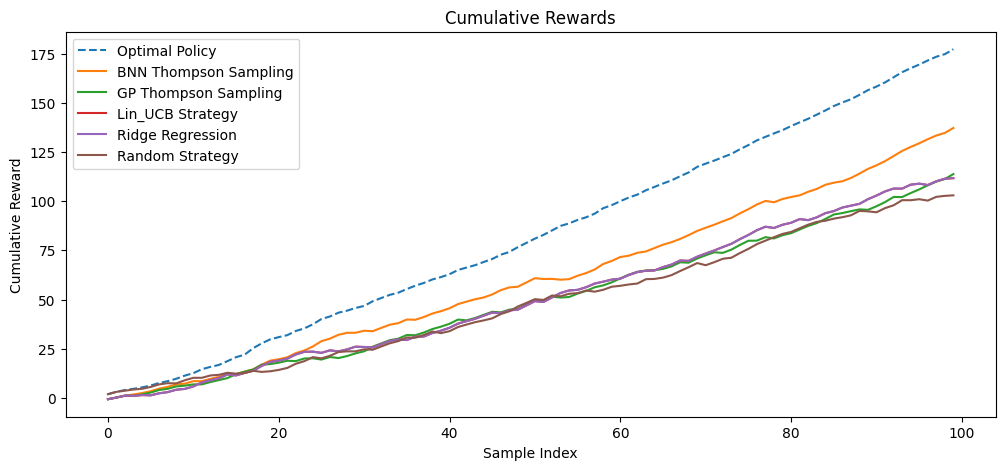

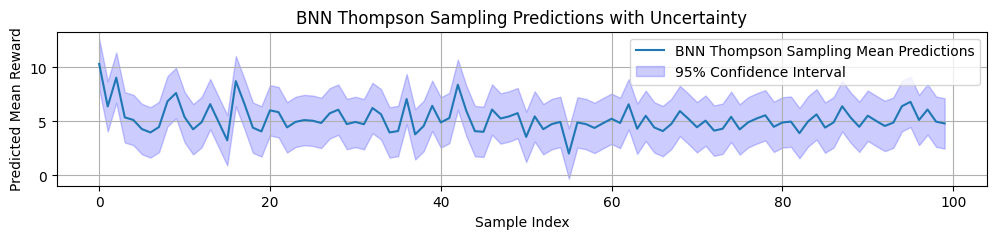

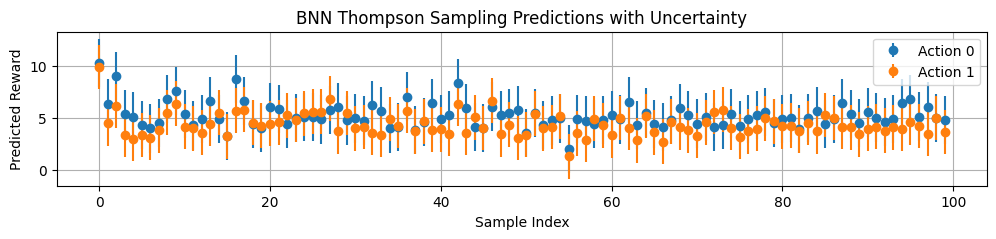

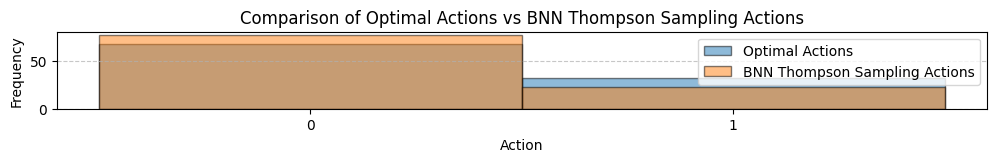

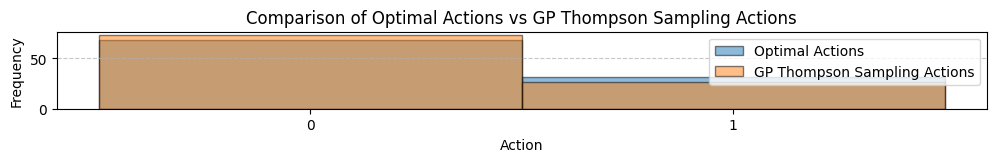

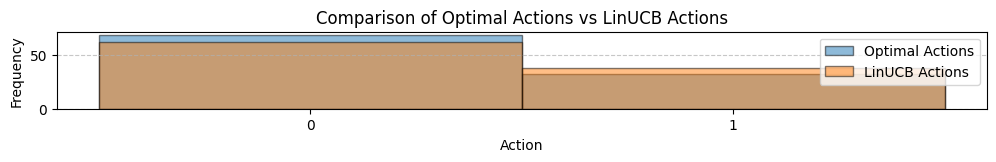

BNN Thompson Sampling Accuracy: 0.7500
BNN Thompson Sampling F1 Score: 0.7373
GP Thompson Sampling Accuracy: 0.6100
GP Thompson Sampling F1 Score: 0.6004
LinUCB Accuracy: 0.5800
LinUCB F1 Score: 0.5883
Ridge Regression Accuracy: 0.5800
Ridge Regression F1 Score: 0.5883
Random Strategy Accuracy: 0.4700
Random Strategy F1 Score: 0.4876


In [150]:
run_backtest(X, total_samples, n_actions, optimal_actions, context_dim,  num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=50)
    

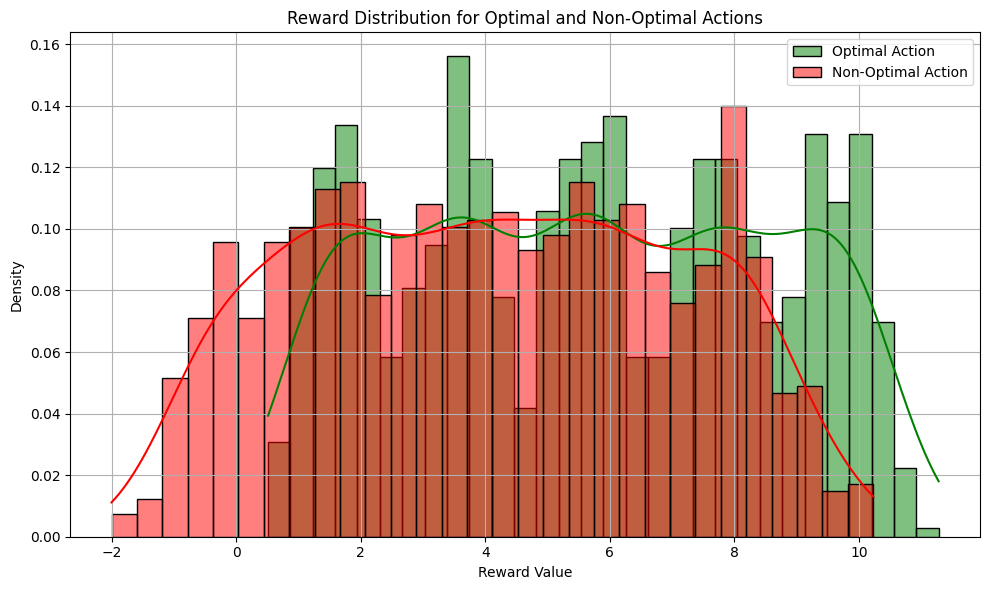

In [153]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

class RewardGenerator:
    def __init__(self, drift_rate=0.005, seasonal_period=400):
        self.drift_rate = drift_rate
        self.seasonal_period = seasonal_period
        self.t = 0  # Initialize time step

    def generate_rewards(self, context, action, optimal_action, n=3):
        """
        Generates rewards with added complexity from context sampling and non-stationarity.

        Parameters:
        - context: np.array, the feature context
        - action: int, the action taken
        - optimal_action: int, the optimal action for this context
        - n: int, number of context features to sample for reward generation

        Returns:
        - reward: float, the generated reward
        """
        # Sample `n` context features
        if len(context) >= n:
            sampled_context = np.random.choice(context, size=n, replace=False)
        else:
            sampled_context = context  # Use all features if fewer than n
        
        # Compute a context factor based on the sampled features
        context_factor = np.sum(sampled_context)
        
        # Non-stationarity (drift and seasonality)
        time_drift = self.drift_rate * self.t
        seasonality = np.sin(2 * np.pi * self.t / self.seasonal_period)
        
        # Calculate reward based on action and non-stationary factors
        if action == optimal_action:
            mean = 1 + 0.2 * context_factor + time_drift + seasonality
            std = 0.1  # Small variance for optimal action
        else:
            mean = 0 + 0.5 * context_factor + time_drift + seasonality
            std = 0.4  # Higher variance for non-optimal action
        
        # Sample reward from Gaussian distribution
        reward = np.random.normal(mean, std)

        # Increment time step for next call
        self.t += 1
        
        return reward


def generate_data(context, total_samples, n_actions, optimal_actions):
    rewards = torch.zeros(total_samples, n_actions)
    reward_gen = RewardGenerator()

    for i in range(total_samples):
        for action in range(n_actions):
            # Generate rewards based on the given logic
            rewards[i, action] = reward_gen.generate_rewards(context[i], action, optimal_actions[i])

    return rewards


# Function to plot reward distributions for optimal and non-optimal actions
def plot_reward_distributions(context, optimal_actions, n_actions=2, n_samples=1000):
    # Generate the reward data
    rewards = generate_data(context, n_samples, n_actions, optimal_actions)
    
    # Initialize lists to store rewards for optimal and non-optimal actions
    optimal_rewards = []
    non_optimal_rewards = []

    # Separate rewards based on whether the action is optimal or non-optimal
    for i in range(n_samples):
        for action in range(n_actions):
            if action == optimal_actions[i]:
                optimal_rewards.append(rewards[i, action].item())
            else:
                non_optimal_rewards.append(rewards[i, action].item())

    # Plot the distributions using seaborn
    plt.figure(figsize=(10, 6))

    # Plot the optimal rewards
    sns.histplot(optimal_rewards, color='green', kde=True, label='Optimal Action', stat='density', bins=30, alpha=0.5)

    # Plot the non-optimal rewards
    sns.histplot(non_optimal_rewards, color='red', kde=True, label='Non-Optimal Action', stat='density', bins=30, alpha=0.5)

    # Add titles and labels
    plt.title('Reward Distribution for Optimal and Non-Optimal Actions')
    plt.xlabel('Reward Value')
    plt.ylabel('Density')

    # Show the legend
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage with simulated data
np.random.seed(42)
torch.manual_seed(42)

# Simulate some context data (1000 samples, 5 features)
n_samples = 1000
n_features = 5
context = X  ##np.random.randn(n_samples, n_features)

# Simulate the optimal actions (randomly assigned between 0 and 1)
optimal_actions = y  #np.random.randint(0, 2, size=n_samples)

# Plot the reward distributions
plot_reward_distributions(context, optimal_actions, n_actions=2, n_samples=n_samples)


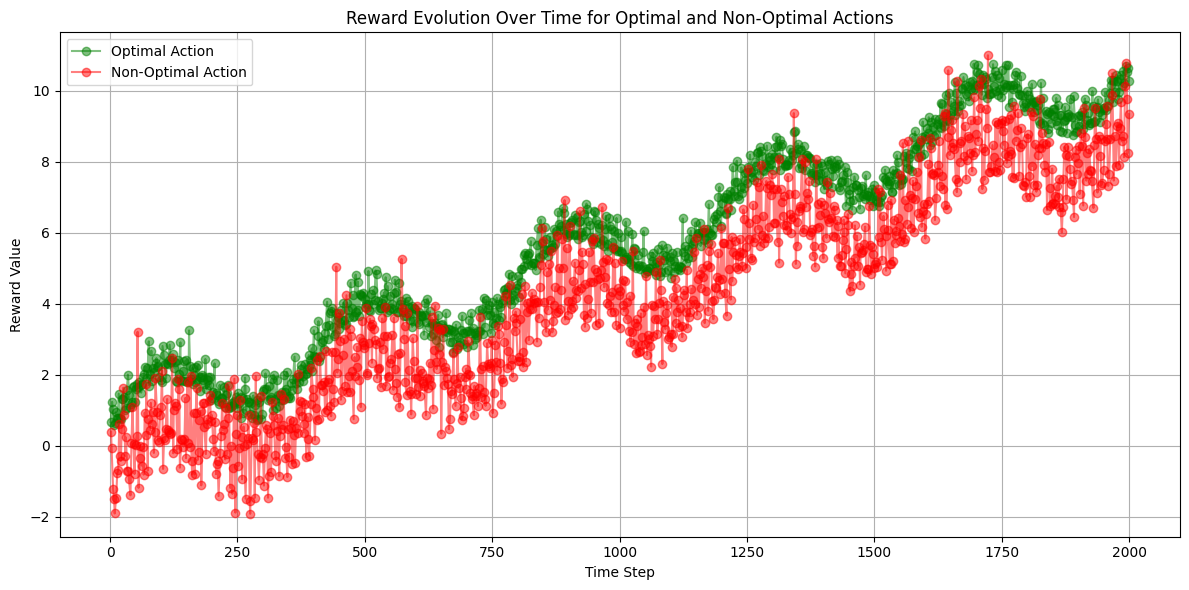

In [154]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Modify the previous plot function to include time series plotting
def plot_reward_distributions_over_time(context, optimal_actions, n_actions=2, n_samples=1000):
    # Generate the reward data
    rewards = generate_data(context, n_samples, n_actions, optimal_actions)
    
    # Initialize lists to store rewards for optimal and non-optimal actions
    optimal_rewards = []
    non_optimal_rewards = []
    times_optimal = []
    times_non_optimal = []

    reward_gen = RewardGenerator()

    # Separate rewards and time steps based on whether the action is optimal or non-optimal
    for i in range(n_samples):
        for action in range(n_actions):
            reward = reward_gen.generate_rewards(context[i], action, optimal_actions[i])
            if action == optimal_actions[i]:
                optimal_rewards.append(reward)
                times_optimal.append(reward_gen.t)
            else:
                non_optimal_rewards.append(reward)
                times_non_optimal.append(reward_gen.t)
    
    # Plot rewards over time
    plt.figure(figsize=(12, 6))

    # Plot the rewards over time for optimal actions
    plt.plot(times_optimal, optimal_rewards, 'go-', label='Optimal Action', alpha=0.5)

    # Plot the rewards over time for non-optimal actions
    plt.plot(times_non_optimal, non_optimal_rewards, 'ro-', label='Non-Optimal Action', alpha=0.5)

    # Add titles and labels
    plt.title('Reward Evolution Over Time for Optimal and Non-Optimal Actions')
    plt.xlabel('Time Step')
    plt.ylabel('Reward Value')

    # Show the legend
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage with simulated data
np.random.seed(42)
torch.manual_seed(42)

# Simulate some context data (1000 samples, 5 features)
n_samples = 1000
n_features = 5
context = X  ##np.random.randn(n_samples, n_features)

# Simulate the optimal actions (randomly assigned between 0 and 1)
optimal_actions = y  ## np.random.randint(0, 2, size=n_samples)

# Plot the reward distributions over time
plot_reward_distributions_over_time(context, optimal_actions, n_actions=2, n_samples=n_samples)
